# Calibration with latent variables (SEAI5R model)
Using generated data, we test if we can infer that a lockdown has happened and how the contact parameters have changed.
To do this, we generate a test trajectory with a lockdown at time $20$. 
The lockdown is implemented by scaling the contact matrices (for work, school, other).
We use the data points up to the lockdown to infer the parameters of the SEAI5R model.
Using the data after lockdown and the inferred parameters, we infer the change of the contact structure.

For the pre-intervention period, we infer the following parameters as well as initial conditions: 
* $\alpha$ (fraction of asymptomatic infectives), 
* $\beta$ (probability of infection on contact), 
* $\gamma_{I_a}$ (rate of recovery for asymptomatic infected individuals),
* $\gamma_{I_s}$ (rate of recovery for symptomatic infected individuals) 
* $\gamma_{E}$ (rate from exposed to activated)
* $\gamma_{A}$ (rate from activated to infected)

For the post-intervention period, we infer the following control parameters: 
* $a_\mathrm{W}$ fraction of work contact, 
* $a_\mathrm{S}$ fraction of social contact, 
* $a_\mathrm{O}$ fraction of other contacts 

In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [3]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

## 1) Generate a trajectory
We generate a test trajectory on a population with four ages groups using UK contact matrix

In [4]:
## population and age classes
M=4  ## number of age classes

my_data = np.genfromtxt('../data/age_structures/UK.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

Ni0=aM+aF;   Ni=np.zeros((M))

# scale the population down to a more manageble level 
Ni[0] = (np.sum(Ni0[0:4])).astype('int')
Ni[1] = (np.sum(Ni0[4:8])).astype('int')
Ni[2] = (np.sum(Ni0[8:12])).astype('int')
Ni[3] = (np.sum(Ni0[12:16])).astype('int')
N=np.sum(Ni)
fi = Ni/N 

# Get individual contact matrices
CH0, CW0, CS0, CO0 = pyross.contactMatrix.UK()


CH = np.zeros((M, M))
CW = np.zeros((M, M))
CS = np.zeros((M, M))
CO = np.zeros((M, M))

for i in range(16):
    CH0[i,:] = CH0[i,:]*Ni0[i]
    CW0[i,:] = CW0[i,:]*Ni0[i]
    CS0[i,:] = CS0[i,:]*Ni0[i]
    CO0[i,:] = CO0[i,:]*Ni0[i]


for i in range(M):
    for j in range(M):
        i1, j1 = i*4, j*4
        CH[i,j] = np.sum( CH0[i1:i1+4, j1:j1+4] )/Ni[i]
        CW[i,j] = np.sum( CW0[i1:i1+4, j1:j1+4] )/Ni[i]
        CS[i,j] = np.sum( CS0[i1:i1+4, j1:j1+4] )/Ni[i]
        CO[i,j] = np.sum( CO0[i1:i1+4, j1:j1+4] )/Ni[i]

Ni = (Ni/5e2).astype('int') # Scale the numbers to avoid numerical problems
N = np.sum(Ni)

In [10]:
# Generate class with contact matrix for SIR model with UK contact structure
generator = pyross.contactMatrix.SIR(CH, CW, CS, CO)

T_intervention = 20 
times= [T_intervention] # temporal boundaries between different contact-behaviour

aW, aS, aO = 0.5, 0.5, 0.4

# prefactors for CW, CS, CO:
interventions = [[1.0,1.0,1.0],      # before first time
                 [aW, aS, aO],       # after first time
                ]         

# generate corresponding contact matrix function
C = generator.interventions_temporal(times=times,interventions=interventions)

In [11]:
beta  = 0.04         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1./7            
gIh   = 1/14
gIc   = 1/14
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter
fh = 0.1 
gE    = 1/5
gA    = 1/3

hh   = 0.1*np.ones(M)       # fraction which goes from Is to hospital
cc   = 0.05*np.ones(M)      # fraction which goes from  hospital to ICU 
mm   = 0.4*np.ones(M)       # mortality from IC
sa = 0  # change in the population, not taken into account by inference at the moment 

# set up initial condition
Ia0 = np.array([10]*M)  # each age group has asymptomatic infectives
Is0 = np.array([10]*M)   # and also symptomatic infectives
R0  = np.zeros((M))
E0  = np.array([100]*M)
A0  = np.array([100]*M)
Ih0  = np.array([10]*M) 
Ic0  = np.array([10]*M) 
Im0  = np.array([10]*M) 
S0  = Ni - (Ia0+Is0+R0+E0+A0+Ih0+Ic0+Im0)

Tf = 100
Nf = Tf+1

parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
              'gIh':gIh,'gIc':gIc,  'gE':gE, 'gA':gA,
              'fsa':fsa, 'fh':fh, 
              'sa':sa, 'hh':hh, 'cc':cc, 'mm':mm}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SEAI5R(parameters, M, Ni)
data = sto_model.simulate(S0, E0, A0, Ia0, Is0, Ih0, Ic0, Im0, C, Tf, Nf)
data_array = data['X']
np.save('SEAI5R_latent_cal_traj.npy', data_array)

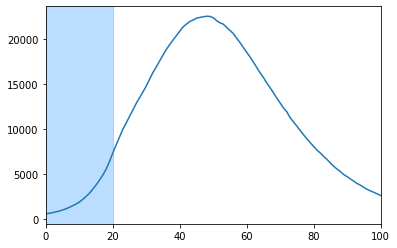

In [12]:
# plot the number of infected people 
plt.plot(np.sum(data_array[:, 2*M:-M], axis=1))
plt.axvspan(0, T_intervention, 
           label='Pre intervention',
           alpha=0.3, color='dodgerblue')
plt.xlim([0, Tf])
plt.show() 

## 2) Inference
We take the first pre-intervention data points of the $I_\mathrm{s}, I_\mathrm{h}, I_\mathrm{c}, I_\mathrm{m}$ trajectory and use it to infer the parameters of the model as well as initial conditions. 

In [13]:
# load the data and rescale to intensive variables 
Tf_inference = T_intervention
Nf_inference = Tf_inference + 1 

x = np.load('SEAI5R_latent_cal_traj.npy').astype('float')
x = x[:Nf_inference,:8*M]/N
steps = 101 # number internal integration steps taken


# initialise the estimator 
estimator = pyross.inference.SEAI5R(parameters, M, fi, int(N), steps)

## create filter to distinguish between observable classes
fltr=np.repeat(np.array([False, False, False, False, True, True, True, True]), M)
obs=x[:,fltr]
x0 = x[0]

# compute -log_p for the original (correct) parameters 
start_time = time.time() 
logp = estimator.minus_logp_red(parameters, x0, obs[1:], fltr, Tf_inference, Nf_inference, generator.constant_CM)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-3204.3379135928476
12.850716829299927


In [19]:
eps = 1e-4 

alpha_g = 0.25          
alpha_std = 0.1
alpha_b = (0.05, 0.5)

beta_g  = 0.06         
beta_std = 0.1
beta_b = (eps, 1)

gIa_g   = 0.13
gIa_std = 0.05 
gIa_b = (0.1, 0.3)

gIs_g   = 0.13
gIs_std = 0.05 
gIs_b = (0.1, 0.3) 

gE_g    = 0.21 
gE_std = 0.05
gE_b = (0.1, 0.3)

gA_g    = 0.35 
gA_std = 0.05 
gA_b = (0.2, 0.5) 
   

E0_g = (E0+10)/N
E0_std = E0_g*0.5
E0_b = [[0.1/N, 200/N]]*M 

A0_g  = (A0-10)/N
A0_std = A0_g*0.5
A0_b = [[0.1/N, 200/N]]*M

Ia0_g = (Ia0+2)/N 
Ia0_std = [5/N]*M
Ia0_b = [(0.1/N, 100/N)]*M

Is0_g = (Is0-3)/N 
Is0_std = [5/N]*M  
Is0_b = [(0.1/N, 100/N)]*M

Ih0_g = (Ih0+0.1)/N 
Ih0_std = [5/N]*M 
Ih0_b = [(0.1/N, 100/N)]*M

Ic0_g = (Ic0+0.1)/N 
Ic0_std = [5/N]*M 
Ic0_b = [(0.1/N, 100/N)]*M

Im0_g = (Im0+0.1)/N 
Im0_std = [5/N]*M 
Im0_b = [(0.1/N, 100/N)]*M

S0_g = (S0-20)/N 
S0_std = E0_std*4 
S0_b = [(1/N, f) for f in fi]



# optimisation parameters 
ftol = 1e-4 # the relative tol in (-logp)   
bounds = np.array([alpha_b, beta_b, gIa_b, gIs_b, gE_b, gA_b, 
                   *S0_b, *E0_b, *A0_b, *Ia0_b, *Is0_b, *Ih0_b, *Ic0_b, *Im0_b])
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, gE_g, gA_g, 
                   *S0_g, *E0_g, *A0_g, *Ia0_g, *Is0_g, *Ih0_g, *Ic0_g, *Im0_g])
stds = np.array([alpha_std, beta_std, gIa_std, gIs_std, gE_std, gA_std, 
                 *S0_std, *E0_std, *A0_std, *Ia0_std, *Is0_std, *Ih0_std, *Ic0_std, *Im0_std])
start_time = time.time()
params = estimator.latent_inference(guess, stds, obs, fltr, Tf_inference, Nf_inference, 
                                    generator.constant_CM, bounds, 
                                    global_max_iter=20, global_ftol_factor=1e3, 
                                    verbose=True, ftol=ftol) 
end_time = time.time()
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 38 (seed=1023645, Fri May  8 18:22:41 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -2.949727698911195e+03 1.0e+00 9.46e-01  9e-04  9e-02 2:03.7
    2     32 -3.203004348032479e+03 1.1e+00 9.08e-01  9e-04  9e-02 4:07.9
    3     48 -3.192612686230521e+03 1.1e+00 8.71e-01  9e-04  9e-02 5:50.5
    4     64 -3.271333427289303e+03 1.1e+00 8.55e-01  8e-04  9e-02 7:39.4
    5     80 -3.176750426325370e+03 1.1e+00 8.38e-01  8e-04  8e-02 9:28.2
    6     96 -3.222527845508748e+03 1.1e+00 8.29e-01  8e-04  8e-02 11:25.0
    7    112 -2.974662798985262e+03 1.1e+00 8.13e-01  8e-04  8e-02 13:18.9
    8    128 -3.030610471573743e+03 1.1e+00 7.99e-01  8e-04  8e-02 15:07.7
    9    144 -2.961547562606264e+03 1.1e+00 7.91e-01  8e-04  8e-02 16:39.2
   10    160 -3.027703119650895e+03 1.2e+00 7.85e-01  8e-04  8e-02 18:18.3
   11    176 -3.101982461918275e+03 1.2e+00 7.81e-01  8e-0

In [20]:
# save the parameters 
np.save('SEAI5R_latent_cal_param.npy', params)

In [21]:
print('True parameters')
print(parameters)

params = np.load('SEAI5R_latent_cal_param.npy')
best_estimates = estimator.make_params_dict(params)
print('\n Best estimates')
print(best_estimates)

print('\n True initial conditions: ') 
print(S0, E0, A0, Ia0, Is0, Ih0, Ic0, Im0)
print('\n Inferred initial conditons: ') 
print((params[6:]*N).astype('int'))

True parameters
{'alpha': 0.2, 'beta': 0.04, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285, 'gIh': 0.07142857142857142, 'gIc': 0.07142857142857142, 'gE': 0.2, 'gA': 0.3333333333333333, 'fsa': 0.8, 'fh': 0.1, 'sa': 0, 'hh': array([0.1, 0.1, 0.1, 0.1]), 'cc': array([0.05, 0.05, 0.05, 0.05]), 'mm': array([0.4, 0.4, 0.4, 0.4])}

 Best estimates
{'alpha': 0.25345253619169983, 'beta': 0.03275836762559821, 'gIa': 0.14844128131506262, 'gIs': 0.1681377946766597, 'gE': 0.262222704148346, 'gA': 0.23891432682194777, 'gIh': 0.07142857142857142, 'gIc': 0.07142857142857142, 'fsa': 0.8, 'fh': 0.1, 'sa': 0, 'hh': array([0.1, 0.1, 0.1, 0.1]), 'cc': array([0.05, 0.05, 0.05, 0.05]), 'mm': array([0.4, 0.4, 0.4, 0.4])}

 True initial conditions: 
[31018. 35418. 35276. 25509.] [100 100 100 100] [100 100 100 100] [10 10 10 10] [10 10 10 10] [10 10 10 10] [10 10 10 10] [10 10 10 10]

 Inferred initial conditons: 
[31044 35403 35365 25501   171    53   136   167    91   184    80    46
    10    10    

### Check the inferred trajectory against the true trajectory for pre-intervention

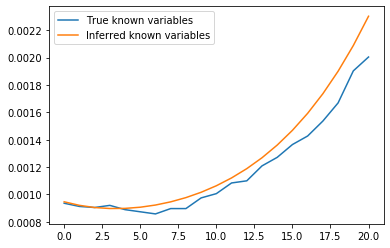

In [23]:
x = np.load('SEAI5R_latent_cal_traj.npy')/N
x0 = params[6:]

# set params for estimate
estimator.set_params(best_estimates)

# make det_model and contactMatrix 
det_model = pyross.deterministic.SEAI5R(best_estimates, M, fi)

# generate the deterministic trajectory 
x_det = estimator.integrate(x0, 0, Tf_inference, Nf_inference, det_model, generator.constant_CM)
plt.plot(np.sum(x[:Nf_inference,5*M:8*M], axis=1), label='True known variables')
plt.plot(np.sum(x_det[:, 5*M:8*M], axis=1), label='Inferred known variables')
plt.legend()
plt.show()

## 3) Infer the control parameters 
We infer the control parameters, assuming that the previously inferred initial conditions and epidemiological parameters 

In [24]:
# Test the -logp for the correct control parameters 

# get the trajectory 
x = np.load('SEAI5R_latent_cal_traj.npy')/N
x = x[Nf_inference:, :8*M]
obs = x[:20, fltr] # cut the trajectory for speed 
Nf_control = obs.shape[0] 
Tf_control = Nf_control-1


# Set the initial condition for post-intervention 
x0_control = np.array(x_det[-1])

# get the contact matrix for post-intervention 
times = [Tf+1]
interventions = [[aW, aS, aO]]
contactMatrix = generator.interventions_temporal(times=times,interventions=interventions)

# calculate minus_log_p for the correct control parameters  
start_time = time.time()
logp = estimator.minus_logp_red(best_estimates, x0_control, obs[1:], fltr, Tf_control, Nf_control, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-1837.9037179331228
15.530404090881348


In [ ]:
# set up initial guess and bounds 
aW_g = 0.5 
aW_std = 0.1
aW_bounds = [0.2, 0.8]

aS_g = 0.55
aS_std = 0.1
aS_bounds = [0.2, 0.8]

aO_g = 0.45
aO_std = 0.1 
aO_bounds = [0.2, 0.8]
guess = np.array([aW_g, aS_g, aO_g])
stds = np.array([aW_std, aS_std, aO_std])
bounds = np.array([aW_bounds, aS_bounds, aO_bounds])

ftol = 1e-4

start_time = time.time() 
estimator.set_params(best_estimates) 
control_params = estimator.latent_infer_control(guess, stds, x0_control, obs, fltr, Tf_control, Nf_control, 
                                              generator, bounds,
                                              global_max_iter=5, global_ftol_factor=1e4, 
                                                verbose=True, 
                                                ftol=ftol)
end_time = time.time()
print(control_params) # best guess 
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 3 (seed=1066835, Fri May  8 15:48:48 2020)


In [25]:
print('True control params:')
print([aW, aS, aO])

print('\n Best estimates')
print(control_params)

True control params:
[0.5, 0.5, 0.4]

 Best estimates


NameError: name 'control_params' is not defined

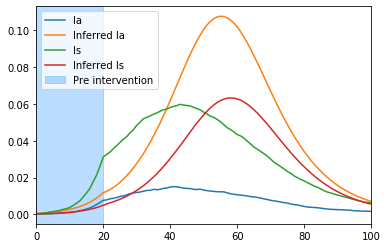

In [39]:
times = [T_intervention]
interventions = [[1.0,1.0,1.0],      # before first time
                 control_params,       # after first time
                ]         

# compare the true trajectory with the 
contactMatrix = generator.interventions_temporal(times=times,interventions=interventions)
det_model = pyross.deterministic.SEAI5R(parameters, M, fi)
x0 = params[6:]
x_det_control = estimator.integrate(x0, 0, Tf, Nf, det_model, contactMatrix)
x = np.load('cal_lat_SIR_traj.npy')/N
plt.plot(np.sum(x[:,M:2*M], axis=1), label='Ia')
plt.plot(np.sum(x_det_control[:, M:2*M], axis=1), label='Inferred Ia')
plt.plot(np.sum(x[:,2*M:3*M], axis=1), label='Is')
plt.plot(np.sum(x_det_control[:, 2*M:3*M], axis=1), label='Inferred Is')
plt.axvspan(0, T_intervention, 
           label='Pre intervention',
           alpha=0.3, color='dodgerblue')
plt.xlim([0, Tf])
plt.legend()
plt.show()